### FordGoBike Project

  * We will try to answer these questions and lastly, we will be comparing performance between year 2017.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import calendar
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import matplotlib.ticker as tick
from math import radians, sin, cos, acos
import math
%matplotlib inline
%matplotlib inline

In [2]:
df = pd.read_csv('2017-fordgobike-tripdata.csv')

In [3]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
duration_sec               519700 non-null int64
start_time                 519700 non-null object
end_time                   519700 non-null object
start_station_id           519700 non-null int64
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null int64
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
bike_id                    519700 non-null int64
user_type                  519700 non-null object
member_birth_year          453159 non-null float64
member_gender              453238 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 59.5+ MB


  * duration_sec needs to be in minutes
  * start_time and end_time needs to be in time format
  * find the distance between end_station_latitude and end_station_longitude
  * find age of member
  

In [5]:
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])

In [6]:
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date

In [7]:
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))


In [8]:
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)


In [9]:
df['start_time_month']=df['start_time'].dt.month.astype(int)
df['end_time_month']=df['end_time'].dt.month.astype(int)


In [10]:
df['start_time_hour_minute']=df['start_time'].map(lambda x: x.strftime('%H-%m'))
df['end_time_hour_minute']=df['end_time'].map(lambda x: x.strftime('%H-%m'))


In [11]:

df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour


In [12]:
df['start_time_weekday']=df['start_time'].dt.weekday_name
df['end_time_weekday']=df['end_time'].dt.weekday_name

In [13]:
df['start_time_weekday_abbr']=df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday_abbr']=df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])


In [14]:
df['duration_min'] = df['duration_sec']/60


In [15]:
df['duration_min'].sample(10)

58282      6.183333
43058      6.900000
160946     3.250000
365809    35.000000
328097     1.783333
147814     6.083333
426730    12.033333
405896    10.450000
457015    36.900000
228180     7.450000
Name: duration_min, dtype: float64

In [16]:
### Calculations were derived from here using Haversine.py
### https://www.movable-type.co.uk/scripts/latlong.html

def distance(origin, destination):

    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [17]:

df['distance_km'] = df.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)

df['distance_miles'] = df['distance_km']*0.621371


In [18]:
df.distance_miles.head(5)

0    0.585910
1    1.907439
2    0.000000
3    0.650341
4    0.395403
Name: distance_miles, dtype: float64

In [19]:
df.shape

(519700, 34)

  * set up visuals with google map cyclist

In [20]:
len(df.member_birth_year )

519700

In [21]:
df['member_age'] = 2019-df['member_birth_year']

In [22]:
df.member_age.count()

453159

  * ISSUES
  * Age groups of people who took bike rides/ per age group
  * Number of daily bike rides
  * Get distance of bike rides
  * Duration of bike rides
  * Bike rides gender
  * Bike rides per weekdays
  * Bike rides per hourly rides
  * Count of rides from subscribers and customers
  * Average duration from sub and cust
  * monthly trends of bike rides per subscribers by age group
  * which docks are used most frequently top 10 stations
  * eBikes launched around April 24th
  * List paths that are most commonly used
  

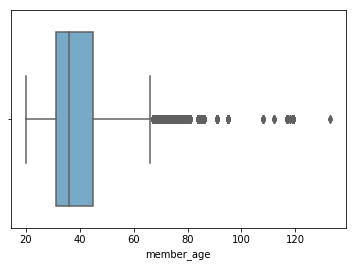

In [23]:
sb.boxplot(x='member_age', data=df, palette='Blues', orient='h')

  * There are outliers in the ages. We will discard these abnormal ages since we are more interested in bikers raing from 20 to 60. 

In [24]:
df=df[df['member_age'] <=60]

In [25]:
np.mean(df.member_age)

37.5353645191863

In [26]:
df.drop(['member_birth_year'], axis=1, inplace=True)

In [27]:
p=figure(height=200)
p.diamond_cross(x=df.member_age , y=df.duration_sec)
show(p)


#### Finding daily number of bike rides 

In [28]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

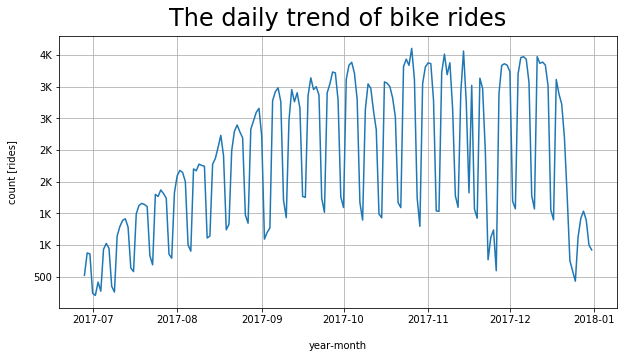

In [29]:
df.groupby('start_time_date').agg('count')['bike_id'].plot(kind = 'line', figsize = [10, 5])
plt.title('The daily trend of bike rides', fontsize=24, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.grid()
plt.savefig('pic1.png')


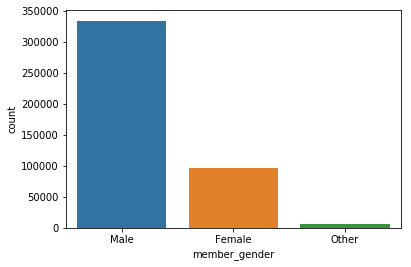

In [30]:
sb.countplot(data = df, x = 'member_gender')
plt.savefig('pic2.png')

  * There are significantly more males cyclists than females and other genders.


In [31]:
trip_by_weekday_df = df.groupby('start_time_weekday_abbr').agg({'bike_id':'count'})
trip_by_weekday_df['perc'] = (trip_by_weekday_df['bike_id']/trip_by_weekday_df['bike_id'].sum())*100


In [32]:
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

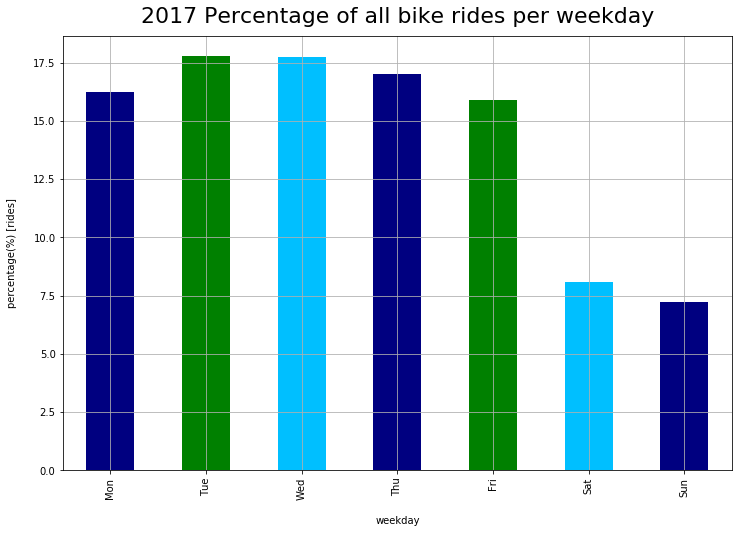

In [33]:
new_color = ['navy', 'green', 'deepskyblue', 'navy', 'green', 'deepskyblue', 'navy']
trip_by_weekday_df.reindex(weekday_index)['perc'].plot(kind='bar', color=new_color, figsize=(12,8), legend=False)
plt.title('2017 Percentage of all bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.savefig('pic3.png')
plt.grid()


In [34]:
trip_by_weekday_df.describe()

,bike_id,perc
count,7.000000,7.000000
mean,62403.142857,14.285714
std,20055.900175,4.591321
min,31614.000000,7.237273
25%,52314.500000,11.976160
50%,71023.000000,16.259025
75%,75954.500000,17.387975
max,77647.000000,17.775433


  * It looks like the most popular days that cyclists ride their bikes is tuesday and wednesday with 16.9% rides.

#### Age Groups bikers per month

  * Creating age groups of cyclists.

In [35]:

df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '21 - 30' if 20<x<=30
                                                  else '31 - 40' if 30<x<=40
                                                  else '41 - 50' if 40<x<=50
                                                  else '51 - 60' if 50<x<=60
                                                  else x)


In [36]:
df.member_age_bins.head(5)

0     31 - 40
1     51 - 60
4     21 - 30
6     21 - 30
12    21 - 30
Name: member_age_bins, dtype: object

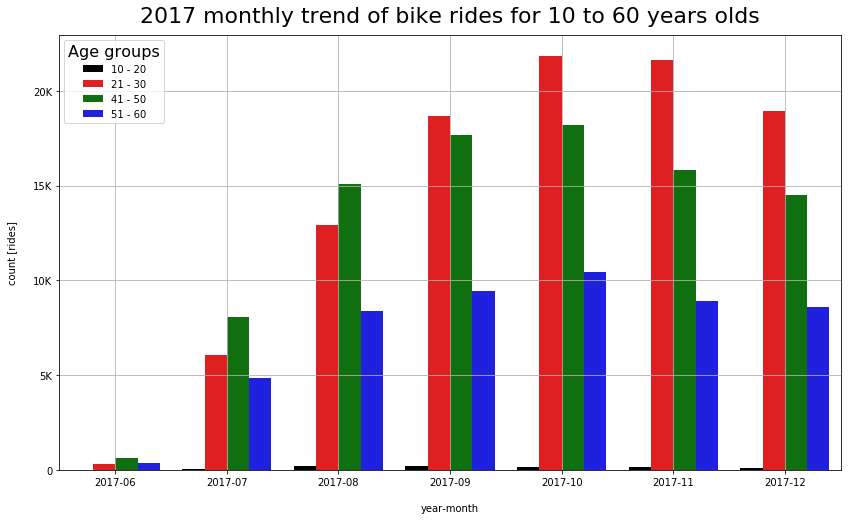

In [37]:
plt.figure(figsize=(14,8))
my_palette = {'10 - 20': 'black', '21 - 30': 'red', '31 - 40': 'blue', '41 - 50': 'green','51 - 60': 'blue'}
ax = sb.countplot(x='start_time_year_month', hue='member_age_bins', palette=my_palette,
                   data=df[df['member_age_bins'].isin(['10 - 20','21 - 30', '31 - 41', '41 - 50', '51 - 60'])].sort_values(by=['start_time_year_month', 'member_age_bins']))
plt.title('2017 monthly trend of bike rides for 10 to 60 years olds', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Age groups',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.grid()
plt.savefig('pic4.png')



In [38]:

trip_by_hour = df.groupby('start_time_hour').agg({'bike_id':'count'}).reset_index()

In [39]:
trip_by_hour['bike_id'] = (trip_by_hour['bike_id']/trip_by_hour['bike_id'].sum())*100

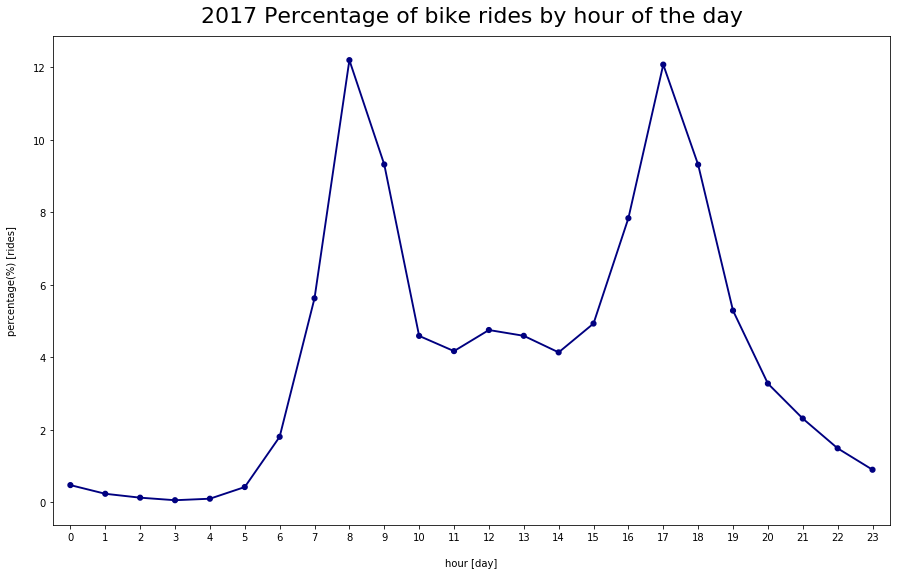

In [40]:
plt.figure(figsize=(15,9))
sb.pointplot(x='start_time_hour', y='bike_id', scale=.7, color='navy', data=trip_by_hour)
plt.title('2017 Percentage of bike rides by hour of the day', fontsize=22, y=1.015)
plt.xlabel('hour [day]', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.savefig('pic5.png')


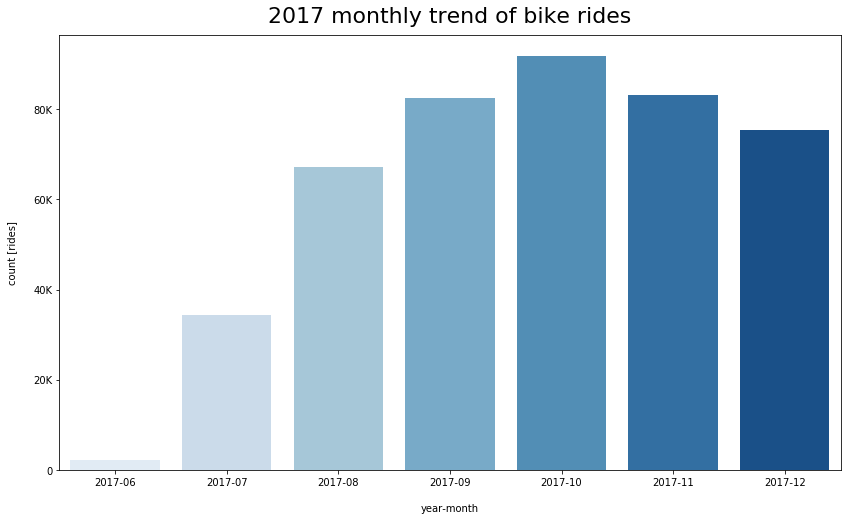

In [41]:
plt.figure(figsize=(14,8))
sb.countplot(x='start_time_year_month', palette="Blues", 
             data=df.sort_values(by='start_time_year_month'))
plt.title('2017 monthly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('pic6.jpg')

#### Percentage of all bike rides per group

In [42]:

trip_by_age_df = df.groupby('member_age_bins').agg({'bike_id':'count'})


In [43]:

trip_by_age_df['perc'] = (trip_by_age_df['bike_id']/trip_by_age_df['bike_id'].sum())*100


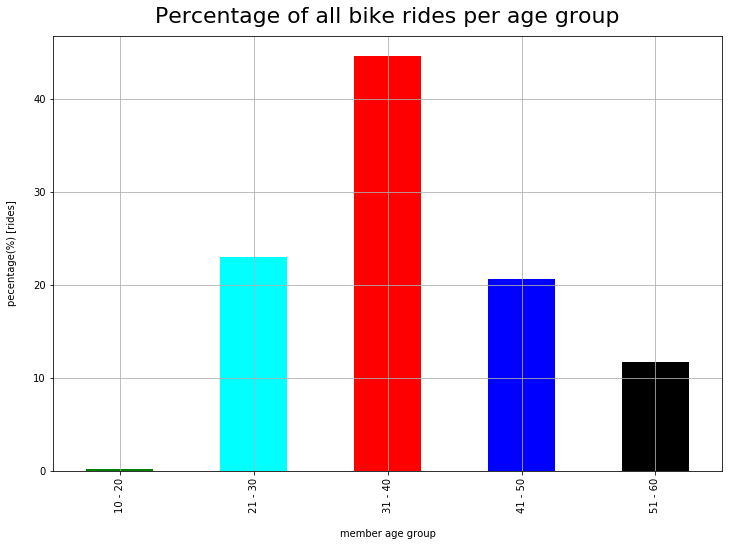

In [44]:

new_color = ['green','cyan', 'red', 'blue', 'black','green','magenta']
trip_by_age_df['perc'].plot(kind='bar', color=new_color, figsize=(12,8))
plt.title('Percentage of all bike rides per age group', fontsize=22, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('pecentage(%) [rides]', labelpad=16)
plt.grid()
plt.savefig('pic7.jpg')

  * count of bike rides of subscribers and customers

In [45]:
count_of_rides_per_user_type = df.groupby('user_type').size().reset_index(name='count')


In [46]:
count_of_rides_per_user_type['count']/len(df)*100

0    10.969457
1    89.030543
Name: count, dtype: float64

In [48]:
user_type_count_per_year_df = df.groupby(["start_time_year_month", "user_type"]).size().reset_index()


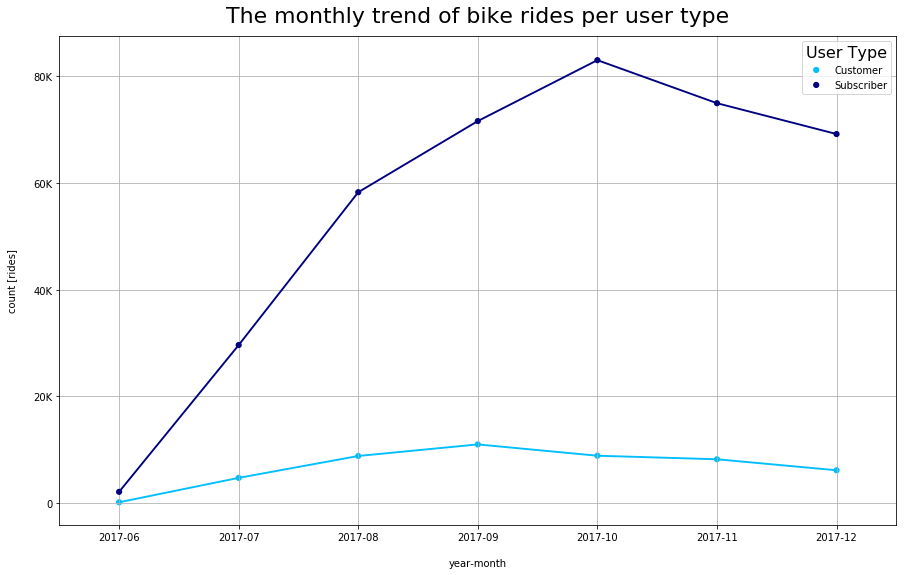

In [50]:

plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'navy', 'Customer':'deepskyblue'}
ax = sb.pointplot(x='start_time_year_month', y=0, hue='user_type', palette=my_palette, scale=.7, 
                  data=user_type_count_per_year_df)
plt.title('The monthly trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.grid()
plt.savefig('pic8.jpg')


In [51]:
df.start_time_year_month.head(5)

0     2017-12
1     2017-12
4     2017-12
6     2017-12
12    2017-12
Name: start_time_year_month, dtype: object

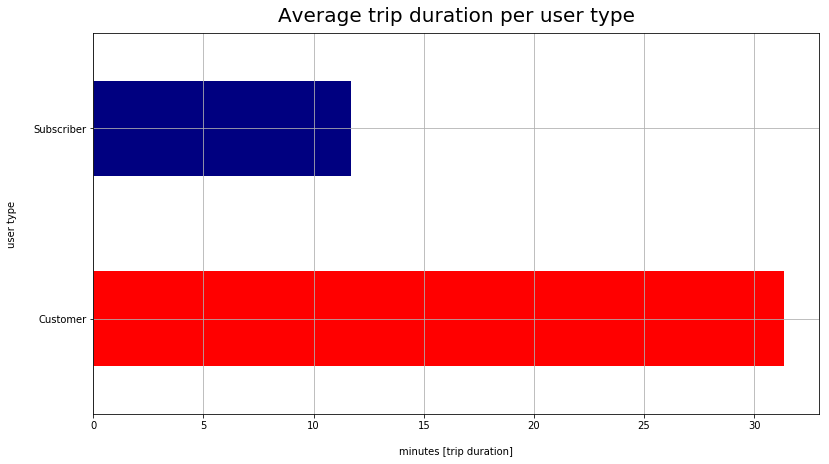

In [52]:
new_color=['red', 'navy']
ax = df.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip duration per user type', fontsize=20, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('minutes [trip duration]', labelpad=16)
plt.grid()
plt.savefig('pic9.jpg')



In [53]:
subscriber_age_df = df[df['user_type']=='Subscriber'].groupby(['start_time_year_month', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()


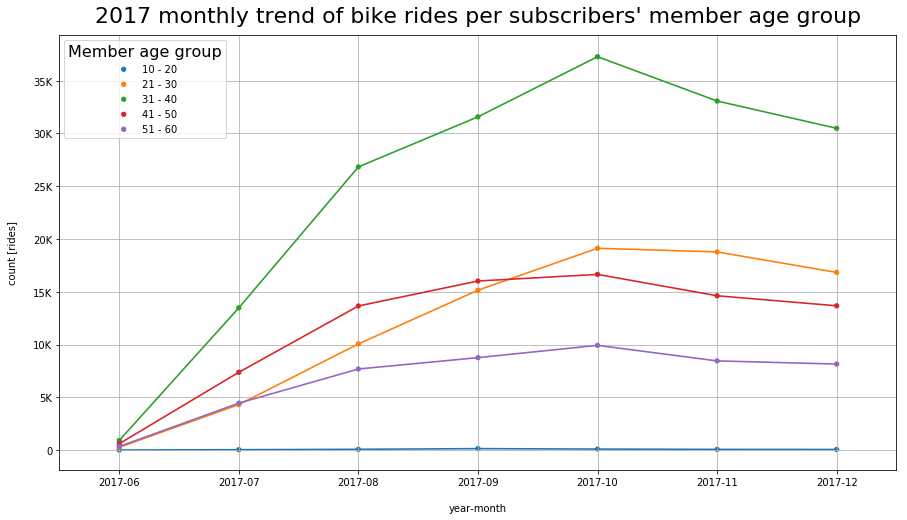

In [54]:
plt.figure(figsize=(15,8))
ax = sb.pointplot(x='start_time_year_month', y='bike_id', hue='member_age_bins', 
                  scale=.6, data=subscriber_age_df)
plt.title("2017 monthly trend of bike rides per subscribers' member age group", fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.grid()
plt.savefig('pic10.jpg')


In [55]:
customer_age_df = df[df['user_type']=='Customer'].groupby(['start_time_year_month', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()


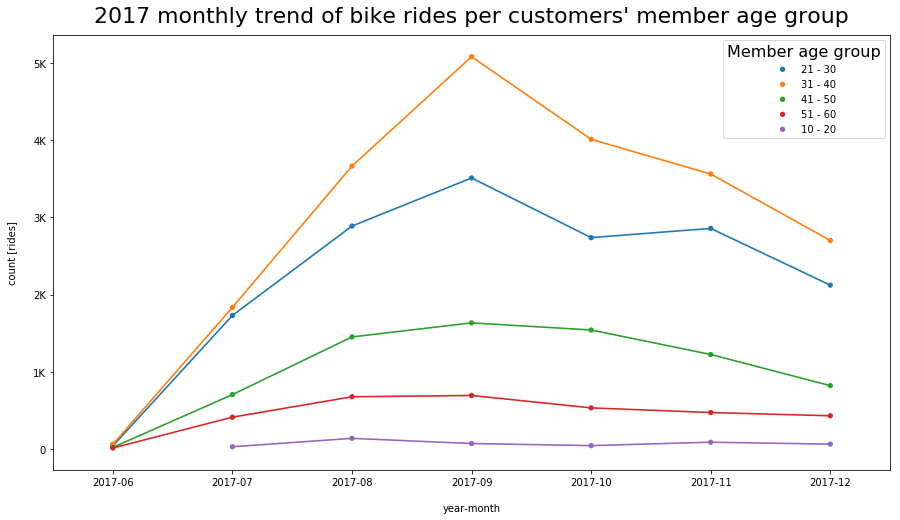

In [56]:
plt.figure(figsize=(15,8))
ax = sb.pointplot(x='start_time_year_month', y='bike_id', hue='member_age_bins', 
                  scale=.6, data=customer_age_df)
plt.title("2017 monthly trend of bike rides per customers' member age group", fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('pic11.jpg')

In [57]:
df.distance_miles.describe()

count    436822.000000
mean          0.995872
std           0.611718
min           0.000000
25%           0.573177
50%           0.877023
75%           1.287788
max          38.707487
Name: distance_miles, dtype: float64

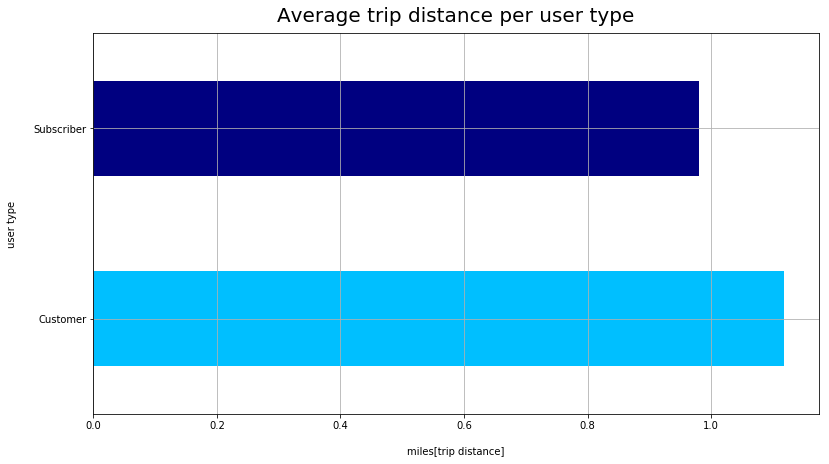

In [58]:
new_color=['deepskyblue', 'navy']
ax = df.groupby('user_type')['distance_miles'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip distance per user type', fontsize=20, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('miles[trip distance]', labelpad=16)
plt.grid()
plt.savefig('pic12.jpg')


In [59]:
df.groupby('user_type')['distance_miles'].mean()

user_type
Customer      1.118364
Subscriber    0.980779
Name: distance_miles, dtype: float64

In [60]:
df.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,end_time_hour,start_time_weekday,end_time_weekday,start_time_weekday_abbr,end_time_weekday_abbr,duration_min,distance_km,distance_miles,member_age,member_age_bins
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,...,15,Sunday,Monday,Sun,Mon,1335.166667,0.942931,0.585910,32.0,31 - 40
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,...,13,Sunday,Monday,Sun,Mon,1313.333333,3.069727,1.907439,54.0,51 - 60
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,...,2,Sunday,Monday,Sun,Mon,726.716667,0.636339,0.395403,22.0,21 - 30
6,4507,2017-12-31 23:49:28.422,2018-01-01 01:04:35.619,259,Addison St at Fourth St,37.866249,-122.299371,259,Addison St at Fourth St,37.866249,...,1,Sunday,Monday,Sun,Mon,75.116667,0.000000,0.000000,28.0,21 - 30
12,2183,2017-12-31 23:52:55.581,2018-01-01 00:29:18.743,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,24,Spear St at Folsom St,37.789677,...,0,Sunday,Monday,Sun,Mon,36.383333,1.517348,0.942836,29.0,21 - 30


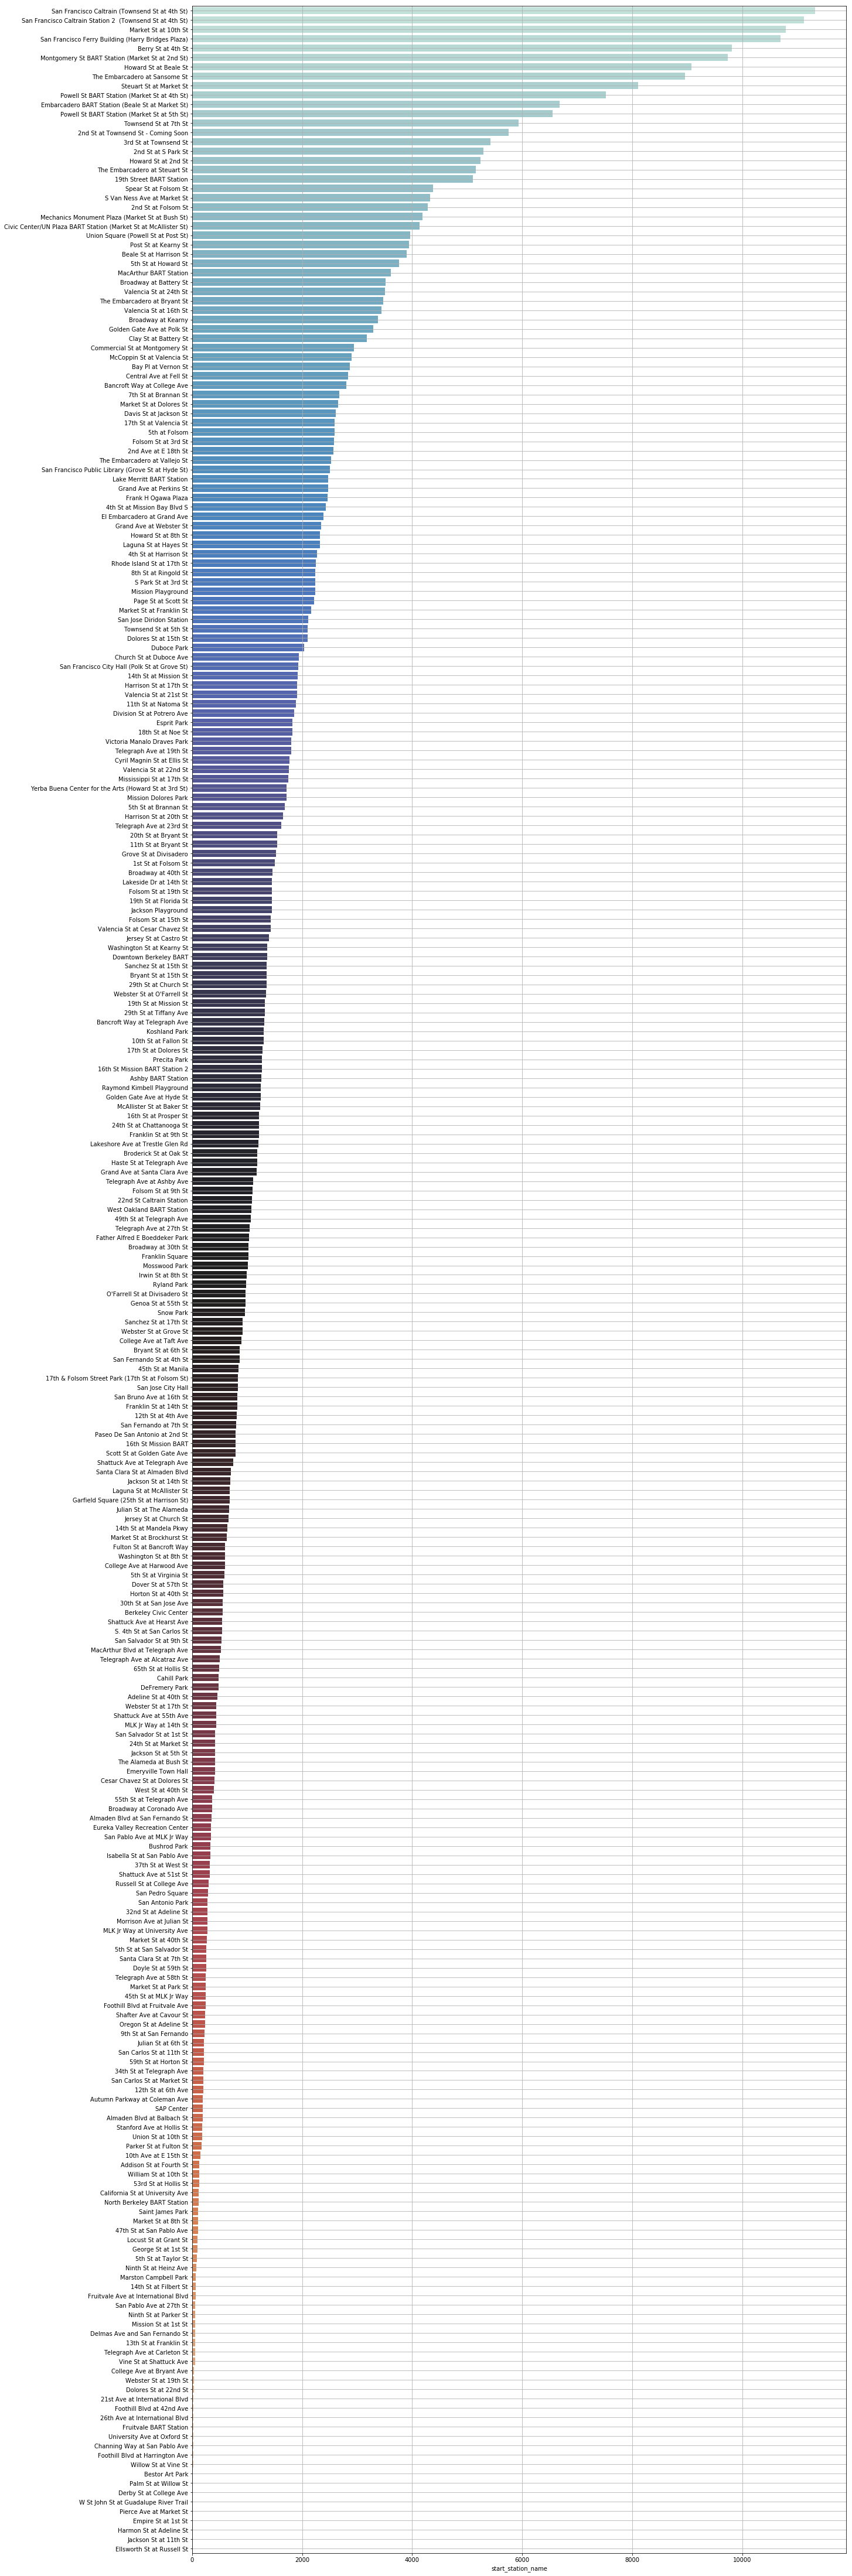

In [61]:
plt.figure(figsize=(20,80))
data=df.start_station_name.value_counts()
sb.barplot(y=data.index, x = data, orient='h',palette='icefire')
plt.grid()
plt.savefig('pic13.jpg')

In [62]:

top_50_popular_station = df.groupby(['start_station_name']).size().sort_values(ascending=False)[:50].to_frame().reset_index().start_station_name




In [63]:
print (top_50_popular_station)

0        San Francisco Caltrain (Townsend St at 4th St)
1     San Francisco Caltrain Station 2  (Townsend St...
2                                  Market St at 10th St
3     San Francisco Ferry Building (Harry Bridges Pl...
4                                    Berry St at 4th St
5      Montgomery St BART Station (Market St at 2nd St)
6                                 Howard St at Beale St
7                         The Embarcadero at Sansome St
8                               Steuart St at Market St
9          Powell St BART Station (Market St at 4th St)
10     Embarcadero BART Station (Beale St at Market St)
11         Powell St BART Station (Market St at 5th St)
12                                Townsend St at 7th St
13                  2nd St at Townsend St - Coming Soon
14                                3rd St at Townsend St
15                                  2nd St at S Park St
16                                  Howard St at 2nd St
17                        The Embarcadero at Ste